In [ ]:
!pip install -qU bbox-utility

# 1) Импортировать необходимые библиотеки

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from google.colab.patches import cv2_imshow

### Подключитесь к Google Диску, чтобы получить сохраненные данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2) Augmentation data

- Поскольку набор данных с медведями в снегу довольно мал, мы решили использовать этот набор данных в качестве тестового набора.
- Мы будем использовать изображение окружающей среды (/arctic_no_bears/) в сочетании с изображением медведя (/bears/) и создадим новый набор данных для обучения.

- Потому что в тестовом наборе данных (с медведем на снегу) размер медведя очень мал по сравнению с размером всего изображения (1/100). Фотографии без медведя (/arctic_no_bears/) довольно большие (средняя длина или ширина будет более 4000 пикселей), а фотография медведя (/bears/) будет около 500 пикселей (длина/ширина). Поэтому мы изменим размер медведя примерно до 10% от исходного размера (50 пикселей), в то же время уменьшите яркость медведя (примерно до 70%), чтобы он соответствовал окружающей среде
- Обратите внимание, что в тестовом наборе максимальное количество медведей на 1 изображении равно 3.
- Обратите внимание, что в тестовом наборе максимальное количество медведей на изображении равно 3, поэтому мы случайным образом добавим 1-> 3 медведя в любую позицию на изображении окружающей среды.

In [ ]:
# Resize a bear
def resize_bear(img, bg_shape):
    bg_w = bg_shape[1]
    bg_h = bg_shape[0]
    min_scale = min(bg_w, bg_h) * 0.01

    scale_percent = 10 # percent of original size
    width = img.shape[1]
    height = img.shape[0]
    if width > height:
        ratio = width / height
        height = int(min_scale)
        width = int(height * ratio)
    else:
        ratio = height / width
        width = int(min_scale)
        height = int(width * ratio)

    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)  
    return resized,resized.shape

# Change brightness
def change_brightness(img_path):
    im = Image.open(img_path).convert('RGB')

    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)

    factor = 0.6 #darkens the image
    im_output = enhancer.enhance(factor)
    img = np.array(im_output.convert('RGB'))
    #cv2_imshow(img)
    
    # Blur img
    random_n = random.randrange(30, 40)
    ksize = (random_n, random_n)
    #print(ksize)
    image = cv2.blur(img, ksize)
    

    return image

In [ ]:
# Image of background
background = np.array(Image.open('/content/drive/MyDrive/hackathon/Минприроды/arctic_no_bears/0.JPG').convert('RGB'))
#background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Image of the object
img_path = '/content/drive/MyDrive/hackathon/Минприроды/bears/bears/1014_0.png'
img = change_brightness(img_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img,_ = resize_bear(img, background.shape)

# Image the object's mask
mask_path = '/content/drive/MyDrive/hackathon/Минприроды/bears/masks/1014_0.png'
mask = np.array(Image.open(mask_path).convert('RGB'))
mask,_ = resize_bear(mask, background.shape)

mask = 255-mask # Invert color of mask

print("Background shape:", background.shape)
print("Image shape:", img.shape)
print("Mask shape:", img.shape)

Background shape: (4912, 7360, 3)
Image shape: (49, 93, 3)
Mask shape: (49, 93, 3)


Уменьшив соответственно длину и ширину медведя, получим

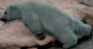

(49, 93, 3)


In [ ]:
cv2_imshow(img)
print(_)

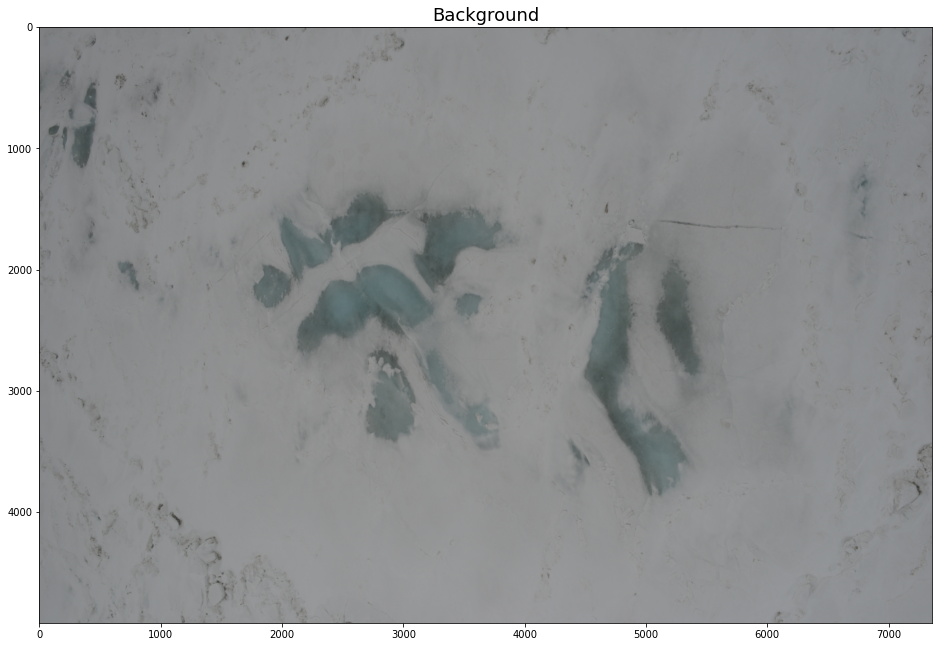

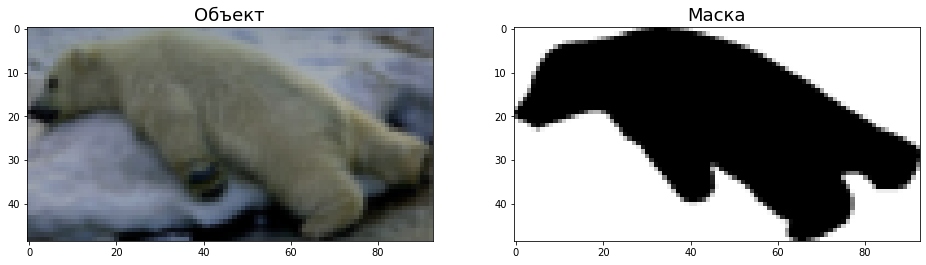

In [ ]:
plt.figure(figsize=(16,16))
plt.title("Background", fontsize=18)
plt.imshow(background);

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Объект', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Маска', fontsize=18);

Мы лишь добавим медведя на изображение окрестностей, убрав вокруг него снег на основе файла mask

Размер изображения объекта:: (193, 367, 3)
Размер маски объекта:: (193, 367)




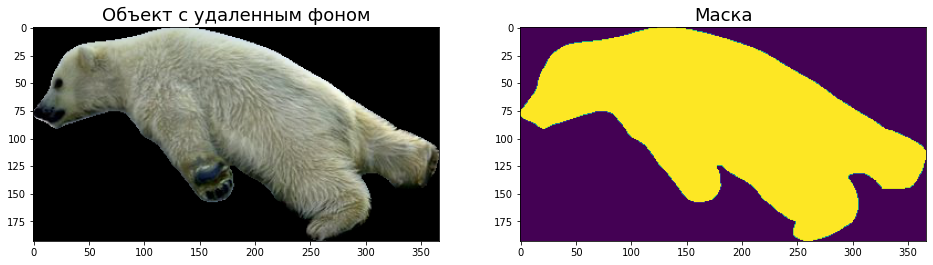

In [ ]:
def remove_obj_background(img_path, mask_path):
    img = np.array(Image.open(img_path).convert('RGB'))
    #img,_ = resize_bear(img)

    mask = np.array(Image.open(mask_path).convert('RGB'))
    #mask,_ = resize_bear(mask)
    mask = 255-mask
    
    h, w = mask.shape[0], mask.shape[1]
    
    mask_boolean = mask[:,:,0] == 0
    img_with_removed_background = img * np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)
    
    return img_with_removed_background, mask_boolean

img_with_removed_background, mask_boolean = remove_obj_background(img_path, mask_path)
print("Размер изображения объекта::", img_with_removed_background.shape)
print("Размер маски объекта::", mask_boolean.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_with_removed_background)
ax[0].set_title('Объект с удаленным фоном', fontsize=18)
ax[1].imshow(mask_boolean)
ax[1].set_title('Маска', fontsize=18);

In [ ]:
# Add bears to background
def add_obj(background, background_mask, img, mask, x, y):
    '''
    Arguments:
    background - background image in CV2 RGB format
    img - image of object in CV2 RGB format
    mask - mask of object in CV2 RGB format
    x, y - coordinates of the center of the object image
    0 < x < width of background
    0 < y < height of background
    
    Function returns background with added object in CV2 RGB format
    
    CV2 RGB format is a numpy array with dimensions width x height x 3
    '''
    
    bg = background.copy()
    bg_mask = background_mask.copy()
    #plt.imshow(bg)
    h_bg, w_bg = bg.shape[0], bg.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    # Calculating coordinates of the top left corner of the object image
    x = x - int(w/2)
    y = y - int(h/2)    
    
    mask_boolean = mask[:,:,0] == 0
    mask_rgb_boolean = np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)
    
    if x >= 0 and y >= 0:
        h_part = h - max(0, y+h-h_bg) # h_part - part of the image which overlaps background along y-axis
        w_part = w - max(0, x+w-w_bg) # w_part - part of the image which overlaps background along x-axis
        #print(bg[y:y+h_part, x:x+w_part, 2].mean())
        #plt.imshow(bg[y:y+h_part, x:x+w_part, :])
        bg[y:y+h_part, x:x+w_part, :] = bg[y:y+h_part, x:x+w_part, :] * ~mask_rgb_boolean[0:h_part, 0:w_part, :] + (img * mask_rgb_boolean)[0:h_part, 0:w_part, :]
        bg_mask[y:y+h_part, x:x+w_part] = bg_mask[y:y+h_part, x:x+w_part]* ~mask_boolean[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        h_part = h + y
        w_part = w + x
        
        bg[0:0+h_part, 0:0+w_part, :] = bg[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_boolean)[h-h_part:h, w-w_part:w, :]
        bg_mask[0:0+h_part, 0:0+w_part] = bg_mask[0:0+h_part, 0:0+w_part] * ~mask_boolean[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        h_part = h - max(0, y+h-h_bg)
        w_part = w + x
        
        bg[y:y+h_part, 0:0+w_part, :] = bg[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[0:h_part, w-w_part:w, :] + (img * mask_rgb_boolean)[0:h_part, w-w_part:w, :]
        bg_mask[y:y+h_part, 0:0+w_part] = bg_mask[y:y+h_part, 0:0+w_part] * ~mask_boolean[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_bg)
        
        bg[0:0+h_part, x:x+w_part, :] = bg[0:0+h_part, x:x+w_part, :] * ~mask_rgb_boolean[h-h_part:h, 0:w_part, :] + (img * mask_rgb_boolean)[h-h_part:h, 0:w_part, :]
        bg_mask[0:0+h_part, x:x+w_part] = bg_mask[0:0+h_part, x:x+w_part] * ~mask_boolean[h-h_part:h, 0:w_part]
    
    return bg, bg_mask

Попробуй добавить 1 медведя в позицию (960, 640) и посмотри на результат

In [ ]:
bg_mask = np.full((background.shape[0], background.shape[1]), 255)
composition_1, composition_1_mask = add_obj(background, bg_mask, img, mask, 960, 640)
#cv2.imwrite("a.jpg", composition_1)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(composition_1)
ax[0].set_title('Новые данные', fontsize=18)
ax[1].imshow(255 - composition_1_mask, cmap='gray')
ax[1].set_title('Новая маска', fontsize=18);

AttributeError: ignored

In [ ]:
#!rm -r /content/drive/MyDrive/hackathon/datasets/images/
#!rm -r /content/drive/MyDrive/hackathon/datasets/masks/

Мы сохраним это вновь созданное изображение в отдельной папке вместе с файлами маски с тем же именем, что и фотографии.

In [ ]:
NEW_DATA_PATH = '/content/drive/MyDrive/hackathon/datasets/'
IMG_PATH = '/content/drive/MyDrive/hackathon/datasets/images/'
MASK_PATH = '/content/drive/MyDrive/hackathon/datasets/masks/'

!mkdir -p {IMG_PATH}
!mkdir -p {MASK_PATH}

In [ ]:
without_bear_path = '/content/drive/MyDrive/hackathon/Минприроды/arctic_no_bears'
bear_path = '/content/drive/MyDrive/hackathon/Минприроды/bears'

list_background = os.listdir(without_bear_path)                 # 1000
list_bear = os.listdir(os.path.join(bear_path, 'bears'))        # 500

#print(list_background)

for background in tqdm(list_background):
    background_img = np.array(Image.open(os.path.join(without_bear_path, background)).convert('RGB'))   # Background img
    background_mask = np.full((background_img.shape[0], background_img.shape[1]), 255)                  # Mask for background
    bg_h, bg_w = background_img.shape[0], background_img.shape[1]
    
    random_bear_number = random.choice([1, 2, 3])

    # Choose number of image of bear
    for i in range(random_bear_number):
        bear_order = random.choice(list_bear)
        bear_img_path = os.path.join(bear_path, 'bears', bear_order)
        bear_mask_path = os.path.join(bear_path, 'masks', bear_order)
        #print(img_path, mask_path)

        bear_img = change_brightness(bear_img_path)
        bear_img, _ = resize_bear(bear_img, background_img.shape)
        mask_img = np.array(Image.open(bear_mask_path).convert('RGB'))
        mask_img, _ = resize_bear(mask_img, background_img.shape)
        mask_img = 255-mask_img

        background_img, background_mask = add_obj(background_img, background_mask, bear_img, mask_img, random.randrange(150, bg_w-150), random.randrange(150, bg_h-150))
    
    background_mask = 255 - background_mask

    background_name = background.split('.')[0]

    # cv2.imwrite("/content/a.jpg", cv2.cvtColor(background_img, cv2.COLOR_RGB2BGR))
    # fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    # ax[0].imshow(background_img)
    # ax[0].set_title('Новые данные', fontsize=18)
    # ax[1].imshow(background_mask, cmap='gray')
    # ax[1].set_title('Новая маска', fontsize=18);
    # break

    cv2.imwrite(f"{IMG_PATH}{background_name}_1.jpg", cv2.cvtColor(background_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"{MASK_PATH}{background_name}_1.jpg", background_mask)

  0%|          | 0/904 [00:00<?, ?it/s]

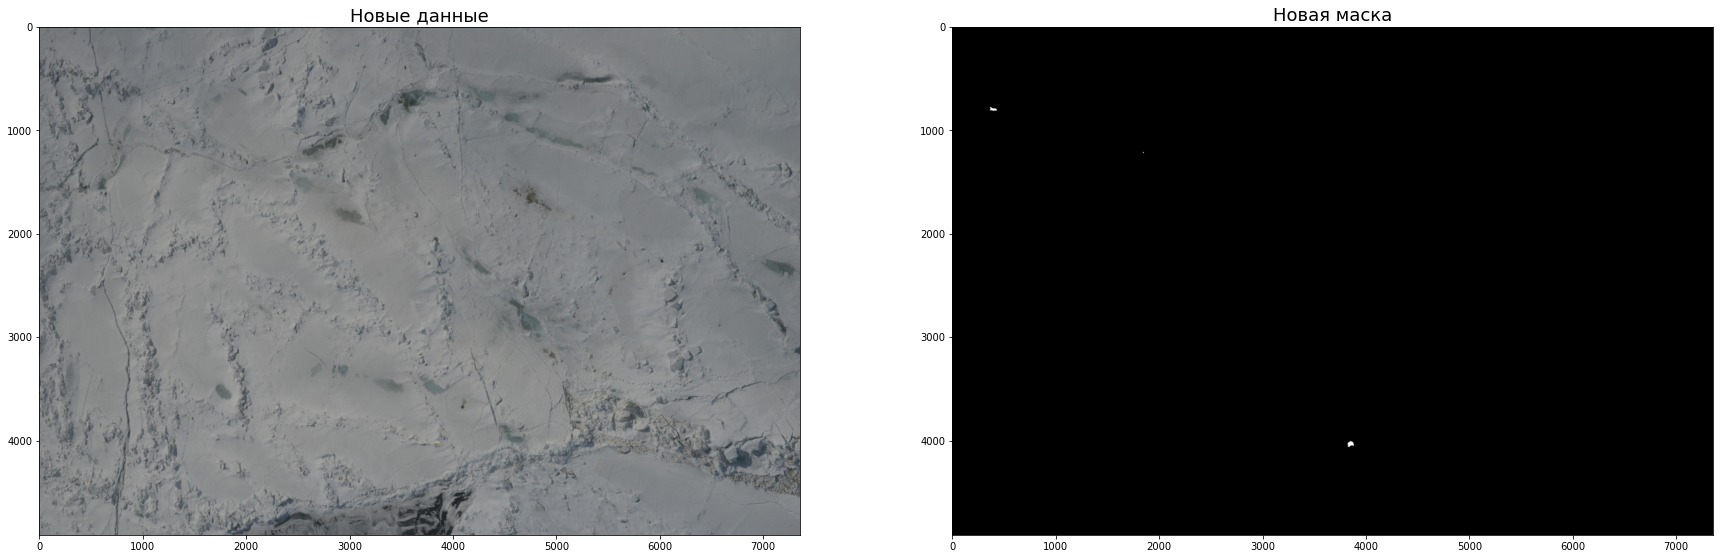

In [ ]:
background_img = np.array(Image.open('/content/drive/MyDrive/hackathon/datasets/images/10.jpg').convert('RGB'))
background_mask = np.array(Image.open('/content/drive/MyDrive/hackathon/datasets/masks/10.jpg'))


fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(background_img)
ax[0].set_title('Новые данные', fontsize=18)
ax[1].imshow(background_mask, cmap='gray')
ax[1].set_title('Новая маска', fontsize=18);

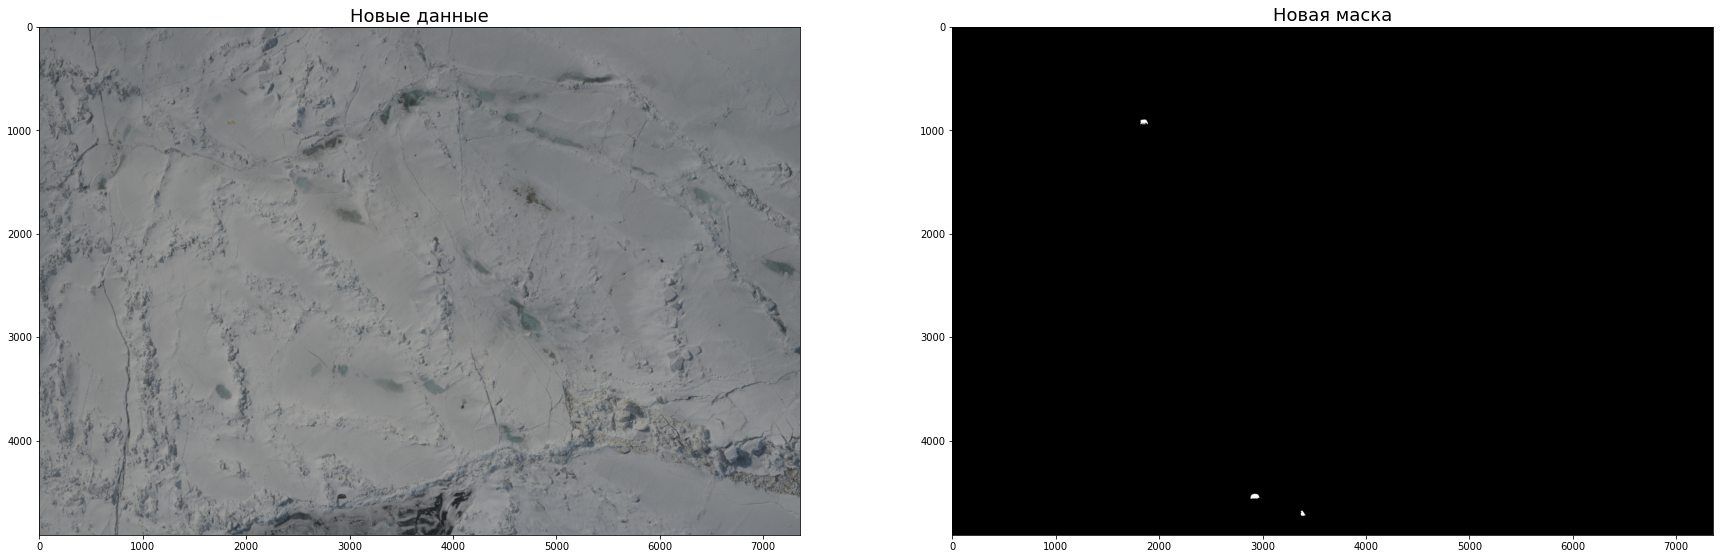

In [ ]:
background_img = np.array(Image.open('/content/drive/MyDrive/hackathon/datasets/images/10_1.jpg').convert('RGB'))
background_mask = np.array(Image.open('/content/drive/MyDrive/hackathon/datasets/masks/10_1.jpg'))


fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].imshow(background_img)
ax[0].set_title('Новые данные', fontsize=18)
ax[1].imshow(background_mask, cmap='gray')
ax[1].set_title('Новая маска', fontsize=18);

# Создать файл аннотации в формате Yolo

- Мы хотим проверить это, используя обнаружение объектов с помощью метода ограничивающей рамки и использовать для этого алгоритм Yolo (потому что он быстрый, точный и современный). Таким образом, мы преобразуем файл маски в текстовый файл, содержащий ограничивающие рамки в формате: `[x_min, y_min, width, height] normalize`

In [ ]:
# YOLO format
LABEL_PATH = '/content/drive/MyDrive/hackathon/datasets/labels'

!mkdir -p {LABEL_PATH}

In [ ]:
from skimage.measure import label, regionprops, find_contours
from glob import glob
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        w = x2 - x1
        h = y2 - y1
        bboxes.append([x1, y1, w, h])

    return bboxes

images = sorted(glob(os.path.join(IMG_PATH, "*_1.jpg")))
masks = sorted(glob(os.path.join(MASK_PATH, "*_1.jpg")))

for x, y in tqdm(zip(images, masks), total=len(images)):
    name = x.split("/")[-1].split(".")[0] + '.txt'
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    w = x.shape[1]
    h = x.shape[0]
    bboxes = mask_to_bbox(y)

    num_bbox = len(bboxes)
    labels = np.array([0]*num_bbox)[..., None].astype(str)
    
    with open(os.path.join(LABEL_PATH, name), 'w') as f:
       for bbox in bboxes:
            x_center = (bbox[0] + bbox[2]/2)/w
            y_center = (bbox[1] + bbox[3]/2)/h
            bb_w = bbox[2] / w
            bb_h = bbox[3] / h
            f.write(f'0 {x_center} {y_center} {bb_w} {bb_h}\n')


  0%|          | 0/904 [00:00<?, ?it/s]

In [ ]:
# старая аугментация
images = sorted(glob(os.path.join(IMG_PATH, "*.jpg")))
masks = sorted(glob(os.path.join(MASK_PATH, "*.jpg")))

for x, y in tqdm(zip(images, masks), total=len(images)):
    name = x.split("/")[-1].split(".")[0] + '.txt'
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    w = x.shape[1]
    h = x.shape[0]
    bboxes = mask_to_bbox(y)

    num_bbox = len(bboxes)
    labels = np.array([0]*num_bbox)[..., None].astype(str)
    
    with open(os.path.join(LABEL_PATH, name), 'w') as f:
       for bbox in bboxes:
            x_center = (bbox[0] + bbox[2]/2)/w
            y_center = (bbox[1] + bbox[3]/2)/h
            bb_w = bbox[2] / w
            bb_h = bbox[3] / h
            f.write(f'0 {x_center} {y_center} {bb_w} {bb_h}\n')


In [ ]:
img = cv2.imread('/content/drive/MyDrive/hackathon/datasets/images/10.jpg')
dh, dw, _ = img.shape

fl = open('/content/drive/MyDrive/hackathon/datasets/labels/10.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img = cv2.imread('/content/drive/MyDrive/hackathon/datasets/images/10_1.jpg')
dh, dw, _ = img.shape

fl = open('/content/drive/MyDrive/hackathon/datasets/labels/10_1.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Создать файл csv для сохранения общей информации

In [ ]:
images = sorted(glob(os.path.join(IMG_PATH, "*_1.jpg")))
masks = sorted(glob(os.path.join(MASK_PATH, "*_1.jpg")))
csv_file = "/content/drive/MyDrive/hackathon/datasets/train.csv"

for x, y in tqdm(zip(images, masks), total=len(images)):
    name = x.split("/")[-1].split(".")[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    w = x.shape[1]
    h = x.shape[0]
    bboxes = mask_to_bbox(y)
    num_bbox = len(bboxes)
    labels = np.array([0]*num_bbox)[..., None].astype(str)

    with open(csv_file, 'a') as f:
       for bbox in bboxes:
            line = name + "," + str(w) + "," + str(h) + ',"' + str(bbox) + '"\n'
            #print(line)
            f.write(line)

  0%|          | 0/904 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
csv_file = "/content/drive/MyDrive/hackathon/datasets/train.csv"
df = pd.read_csv(csv_file)
df

,image_id,width,height,bbox
0,0,7360,4912,"[4830, 4275, 66, 46]"
1,0,7360,4912,"[3537, 4646, 73, 23]"
2,1,7360,4912,"[447, 3073, 53, 142]"
3,10,7360,4912,"[359, 773, 79, 37]"
4,10,7360,4912,"[1845, 1207, 11, 13]"
...,...,...,...,...
2110,998,7360,4912,"[1464, 1948, 18, 15]"
2111,998,7360,4912,"[1466, 1965, 2, 2]"
2112,999,7360,4912,"[6689, 954, 103, 104]"
2113,999,7360,4912,"[4598, 963, 109, 52]"


# New dataset

In [ ]:
NEW_DATA = '/content/drive/MyDrive/hackathon/datasets/asdasd.v1i.yolov5pytorch/train/'

with open(csv_file, 'a') as f:   
    for x in os.listdir(os.path.join(NEW_DATA, 'labels')):
        file_name = x.split(".txt")[0]
        img = np.array(Image.open(os.path.join(NEW_DATA, 'images', file_name + '.jpg')))
        img_w = img.shape[1]
        img_h = img.shape[0]

        bboxes = open(os.path.join(NEW_DATA, 'labels', x), 'r')
        for bbox in bboxes:
            lst_bbox = [float(x) for x in bbox.split(" ")]
            bbox_w = int(lst_bbox[3] * img_w)
            bbox_h = int(lst_bbox[4] * img_h)
            bbox_x = int(lst_bbox[1] * img_w - bbox_w / 2)
            bbox_y = int(lst_bbox[2] * img_h - bbox_h / 2)
            bbox_coco = [bbox_x, bbox_y, bbox_w, bbox_h]
            line = file_name + ',' + str(img_w) + ',' + str(img_h) + ',"' + str(bbox_coco) + '"\n'
            f.write(line)
            #print(line)


In [211]:
%cd /content/drive/MyDrive/hackathon/training/Yolov5/yolov5

/content/drive/MyDrive/hackathon/training/Yolov5/yolov5


In [ ]:
!python detect.py --source /content/drive/MyDrive/hackathon/datasets/test/images  --imgsz 2000 --weight /content/drive/MyDrive/hackathon/training/Yolov5/yolov5/polarbear/yolov5l6-dim2100-fold1/weights/best.pt

detect: weights=['/content/drive/MyDrive/hackathon/training/Yolov5/yolov5/polarbear/yolov5l6-dim2100-fold1/weights/best.pt'], source=/content/drive/MyDrive/hackathon/datasets/test, data=data/coco128.yaml, imgsz=[2000, 2000], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-159-gd669a74 Python-3.7.14 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 346 layers, 76118664 parameters, 0 gradients
WARNING ⚠️ --img-size [2000, 2000] must be multiple of max stride 64, updating to [2048, 2048]
Traceback (most recent call last):
  File "detect.py", line 257, in <module>
    main(opt)
  File "detect.py", line 252, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/d